#### Import necessary libraries 

In [2]:
import numpy as np
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, DataStructs, PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from deepchem import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from deepchem import metrics
import deepchem as dc
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#### Read in the preprocessed BBB dataset from Adenot paper

In [3]:
bbb_df = pd.read_csv('adenot_processed.csv')

In [4]:
bbb_df.head()

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Split

#### Data preprocessing

In [5]:
X = bbb_df.iloc[:,3:].copy()
y = bbb_df.iloc[:,2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### XGBoost

In [6]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)
# make predictions for test data
y_pred = xgboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9600798403193613


#### Hyperparameter Optimization

In [7]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, ), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [8]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 5.88095555,  6.23247957,  6.59109678,  7.36280227,  8.14010725,
          7.46198697, 10.10175438,  9.15995088,  7.82379375, 11.15233603,
          8.0933558 ,  5.77161117]),
  'std_fit_time': array([0.26120178, 1.11973825, 0.7194535 , 0.40431199, 0.09742207,
         0.4983409 , 0.30042583, 0.33562977, 0.11116064, 0.31679037,
         1.02980462, 0.4494667 ]),
  'mean_score_time': array([0.07294888, 0.0871655 , 0.09222374, 0.07515159, 0.08300948,
         0.09008923, 0.06915293, 0.06752114, 0.07740889, 0.09728556,
         0.068502  , 0.05979857]),
  'std_score_time': array([0.01145132, 0.01212464, 0.01602938, 0.01028838, 0.00875629,
         0.01497475, 0.0028051 , 0.00573614, 0.00591998, 0.03986655,
         0.0052556 , 0.00607211]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [9]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'max_depth': [2, 3, 4], 'min_child_weight': [2, 3, 4]},
             scoring='roc_auc')

In [10]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([3.30053625, 3.53181801, 3.84396467, 5.04577293, 4.26021938,
         4.59176435, 5.24775324, 4.8676456 , 4.44462247]),
  'std_fit_time': array([0.14514546, 0.04129332, 0.30306715, 0.08885719, 0.07077158,
         0.17852187, 0.31494898, 0.04862714, 0.86997842]),
  'mean_score_time': array([0.06260624, 0.06322179, 0.06681209, 0.0693469 , 0.06672091,
         0.07831588, 0.07235627, 0.07023215, 0.06505265]),
  'std_score_time': array([0.00216189, 0.0023161 , 0.00505137, 0.00803007, 0.00563105,
         0.0082989 , 0.00481219, 0.00312314, 0.01448857]),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         

In [11]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='roc_auc')

In [12]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([4.59898067, 5.29322166, 5.13639231, 4.58620434, 3.8455183 ]),
  'std_fit_time': array([0.43784099, 0.23705155, 0.11223996, 0.31374805, 1.07041991]),
  'mean_score_time': array([0.06093502, 0.06287746, 0.0648891 , 0.06367908, 0.05205073]),
  'std_score_time': array([0.00126805, 0.00351199, 0.00979477, 0.00494634, 0.01110014]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.97440217, 0.97244565, 0.97548913, 0.97603261, 0.97266304]),
  'split1_test_score': array([0.97858696, 0.97923913, 0.97945652, 0.9773913 , 0.97630435]),
  'split2_test_score': array([0.93453338, 0.93378335, 0.93351548, 0.93153327, 0.93110468]),
  'split3_test_score': array([0.94469945, 0.94622951, 0.94486339, 0.94721311, 0.94907104]),

In [13]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='roc_auc')

In [14]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([3.77738004, 4.24409065, 4.15324821, 4.29364796, 3.89626398,
         4.24887843, 4.42193489, 4.53768539, 4.31859269, 4.63401604,
         5.10120239, 5.44934483, 5.08730531, 5.38560534, 5.8828187 ,
         6.1373651 ]),
  'std_fit_time': array([0.24222134, 0.19532555, 0.01990255, 0.02821242, 0.11736055,
         0.08881863, 0.1184123 , 0.05812851, 0.09278045, 0.07533224,
         0.11908095, 0.03176498, 0.03793538, 0.14102017, 0.1375601 ,
         0.28879018]),
  'mean_score_time': array([0.05901041, 0.05893297, 0.06716924, 0.05959978, 0.05893373,
         0.05945573, 0.06120005, 0.06051841, 0.06405554, 0.06467142,
         0.06437755, 0.06527138, 0.06659904, 0.06429958, 0.06948285,
         0.06392655]),
  'std_score_time': array([0.00300667, 0.00115008, 0.0111922 , 0.00141708, 0.00045258,
         0.00128163, 0.0047722 , 0.00287232, 0.0043723 , 0.00327473,
         0.00257182, 0.00322022, 0.00338496, 0.00295154, 0.00541183,
         0.01172411]),
  'param_c

In [15]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'subsample': [0.75, 0.8, 0.85]},
             scoring='roc_auc')

In [16]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([5.22665138, 5.25007558, 6.14308953, 6.48484187, 5.95687962,
         5.77487593, 6.81449604, 5.81740675, 4.85415435]),
  'std_fit_time': array([0.1181998 , 0.17883354, 0.51312311, 0.05383876, 0.38529689,
         0.61453816, 0.2662023 , 0.67423484, 1.27630438]),
  'mean_score_time': array([0.06032877, 0.06096101, 0.0652143 , 0.07633758, 0.0606523 ,
         0.06320014, 0.07892318, 0.06066647, 0.05449662]),
  'std_score_time': array([0.00182834, 0.00222587, 0.00610782, 0.00870431, 0.0039994 ,
         0.00302393, 0.01757412, 0.00496885, 0.01305377]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, False, False, False, False, False, Fals

In [17]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='roc_auc')

In [18]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([4.88184199, 5.22920499, 5.34662142, 4.91279969, 2.59504352]),
  'std_fit_time': array([0.16319565, 0.08042177, 0.03385129, 0.23306588, 0.62486414]),
  'mean_score_time': array([0.05978503, 0.06234479, 0.06238108, 0.05714402, 0.05129614]),
  'std_score_time': array([0.00057318, 0.00564549, 0.00511845, 0.00135566, 0.01072956]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.97483696, 0.97494565, 0.97483696, 0.97309783, 0.93048913]),
  'split1_test_score': array([0.97304348, 0.97173913, 0.97336957, 0.97336957, 0.91494565]),
  'split2_test_score': array([0.92510447, 0.92681881, 0.92531876, 0.92585449, 0.89081753]),
  'split3_test_score': array([0.95060109, 0.95005464, 0.94961749,

In [19]:
param_test7 = {
 'reg_alpha':[1e-05,1e-06,1e-04,1e-07]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 1e-06, 0.0001, 1e-07]},
             scoring='roc_auc')

In [20]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([5.09706836, 5.22438745, 5.33417253, 5.88961539]),
  'std_fit_time': array([0.06128445, 0.0521913 , 0.03870874, 0.25928876]),
  'mean_score_time': array([0.05972381, 0.06210485, 0.05878201, 0.0656395 ]),
  'std_score_time': array([0.00113211, 0.00557702, 0.00135356, 0.00401135]),
  'param_reg_alpha': masked_array(data=[1e-05, 1e-06, 0.0001, 1e-07],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 1e-06},
   {'reg_alpha': 0.0001},
   {'reg_alpha': 1e-07}],
  'split0_test_score': array([0.97483696, 0.97483696, 0.97483696, 0.97483696]),
  'split1_test_score': array([0.97304348, 0.97304348, 0.97304348, 0.97304348]),
  'split2_test_score': array([0.92510447, 0.92510447, 0.92510447, 0.92510447]),
  'split3_test_score': array([0.95060109, 0.95060109, 0.95060109, 0.95060109]),
  'split4_test_score': array([0.95814208, 0.95814208, 0.95814208, 0.95814208]),
  'mean_

#### Optimized XGBoost

In [21]:
xg_best = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,)

In [22]:
xg_best.fit(X_train, y_train)
# make predictions for test data
y_pred = xg_best.predict(X_test)

#### Feature Importances

In [23]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [24]:
len(non_zero_importance)

131

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

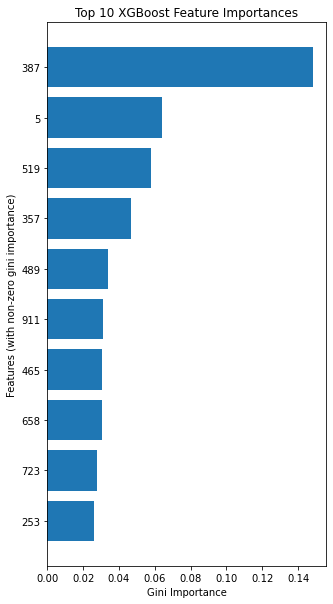

In [25]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][121:], feature_importance['Importance'][121:])
plt.title('Top 10 XGBoost Feature Importances')

### Random Split PCA, DR, and Result Metrics

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Random Split Metrics:
Accuracy: 0.9560878243512974
Balanced Accuracy: 0.9162718204488778
ROC AUC: 0.9162718204488777
Precision Score: 0.9633251833740831
Recall Score: 0.9825436408977556



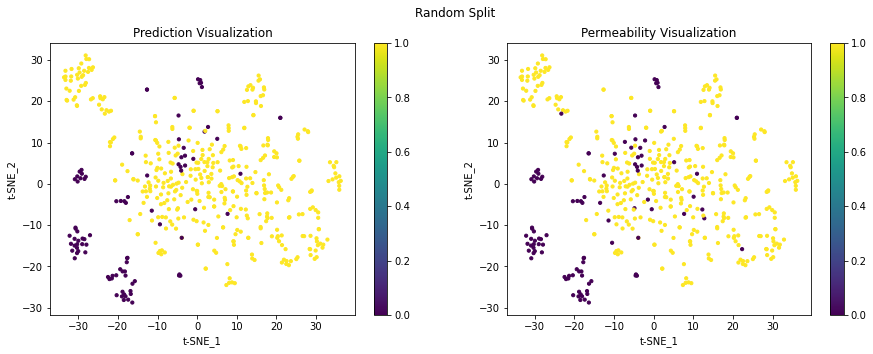

In [27]:
def plot_split(split, y_pred, y_test, t_components):
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('{} Split'.format(split))
    plt.subplot(1, 2, 1)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_pred, s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Prediction Visualization')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_test,s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Permeability Visualization')
    plt.colorbar()
    
    # Calculate how often the classifier is correct
    print("{} Split Metrics:".format(split))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
    print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))
    print("Precision Score:", metrics.precision_score(y_test, y_pred))
    print("Recall Score:", metrics.recall_score(y_test, y_pred))
    print("")

dim = 100
pca_rand = PCA(n_components=dim)
components_rand = pca_rand.fit_transform(X_test)
tsne_rand = TSNE(n_components=2)
t_components_rand = tsne_rand.fit_transform(components_rand)

plot_split('Random', y_pred, y_test, t_components_rand)


### Scaffold Split 

#### Data preprocessing

In [28]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

### Model Predictions (Classes and Probabilities)

In [29]:
# Train Decision Tree classifier
xg_best = xg_best.fit(train_scaff.X,train_scaff.y)

# Predict the response for test dataset
y_pred_scaff = xg_best.predict(test_scaff.X)

In [30]:
y_pred_scaff_prob = xg_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
31,CNC1=Nc2ccc(cc2C(=[N+]([O-])C1)c1ccccc1)Cl,0.999998
157,Oc1noc2c1CCNC2,0.999992
71,Cc1ccc2n3c4c(c2c1)CCCC4NCC3,0.999991
33,Brc1ccc2c(c1)C(=NCC(=O)N2)c1ccccn1,0.999991
131,C1CNCc2cc3ccccc3n2C1,0.999988
...,...,...
275,N[C@@H](C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000182
215,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,0.000128
199,COc1cccc2c1C(=O)c1c(c3c(c(c1C2=O)O)C[C@](O)(C[...,0.000101
265,CO[C@]1(NC(=O)C2SC(S2)=C(C(N)=O)C(O)=O)[C@H]2S...,0.000100


### Scaffold Split PCA, DR, and Result Metrics

In [31]:
dim = 100
pca_scaff = PCA(n_components=dim)
components_scaff = pca_scaff.fit_transform(test_scaff.X)

In [32]:
tsne_scaff = TSNE(n_components=2)
t_components_scaff = tsne_scaff.fit_transform(components_scaff)

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Scaffold Split Metrics:
Accuracy: 0.8802395209580839
Balanced Accuracy: 0.8628717387338076
ROC AUC: 0.8628717387338077
Precision Score: 0.8281938325991189
Recall Score: 0.9947089947089947



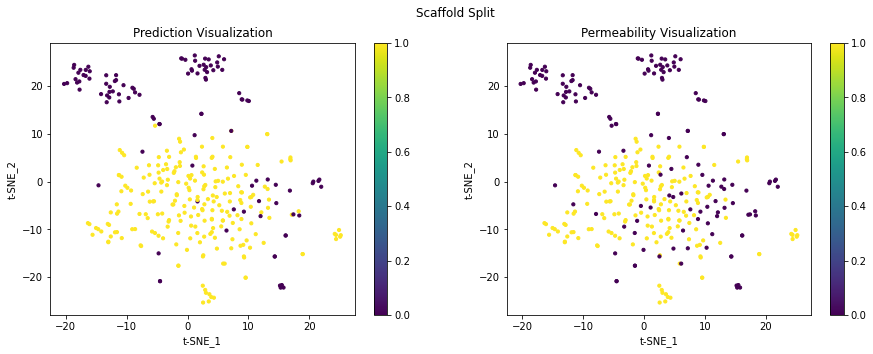

In [33]:
plot_split('Scaffold', y_pred_scaff, test_scaff.y, t_components_scaff)

## Scaffold Split Feature Importances

In [34]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [35]:
len(non_zero_importance)

112

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

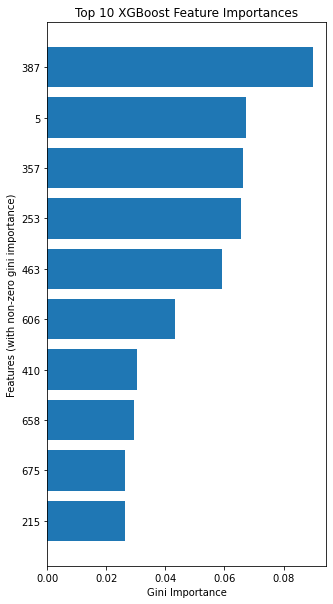

In [36]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 XGBoost Feature Importances')